In [1]:
import torch 

results_dir = "/data/users/igeorvasilis/ddpm_cl/cifar10" 

pretrained_model_dirs = [
    { "dir": f"{results_dir}/lin_sched/no_mask/0", "title": "T1", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m0", "title": "MT1", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/0_from_1", "title": "T1 from T2", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m0_from_m1", "title": "T1 from MT2", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/1", "title": "T2", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m1", "title": "MT2", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/1_from_0", "title": "T2 from T1", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m1_from_m0", "title": "T2 from MT1", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/0n1", "title": "T1 & T2", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/0n1_from_0", "title": "T1 & T2 from T1", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m0n1_from_m0", "title": "T1 & T2 from MT1", "images": None},
    { "dir": f"{results_dir}/lin_sched/no_mask/0n1_from_1", "title": "T1 & T2 from T2", "images": None},
    { "dir": f"{results_dir}/lin_sched/mask/m0n1_from_m1", "title": "T1 & T2 from MT2", "images": None},
]

In [2]:
def get_img_given_title(title):
    for key in pretrained_model_dirs:
        if key["title"] == title:
            return key["images"]
    return None

In [3]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils import make_image_grid
from pipelines import TS_DDIMPipeline
from diffusers import DDIMPipeline

for experiment in pretrained_model_dirs:
    
    model = UNet2DModel.from_pretrained(f'{experiment["dir"]}/epoch-200', subfolder="unet", use_safetensors=True).to('cuda:0')
    noise_scheduler = DDPMScheduler.from_pretrained(f'{experiment["dir"]}/epoch-200', subfolder="scheduler", use_safetensors=True)
    
    # load args.pt 
    experiment_args = torch.load(f"{experiment['dir']}/args.pt")
    #pipeline = DDIMPipeline(unet=model, scheduler=noise_scheduler)
    pipeline = TS_DDIMPipeline(unet=model, scheduler=noise_scheduler, labels=[0, 1])
    pipeline.set_progress_bar_config(disable=True)

    with torch.no_grad(): images = pipeline(
            batch_size=32, num_inference_steps=50, 
            generator=torch.manual_seed(0)
    ).images

    # Save the images
    image_grid = make_image_grid(images, rows=4, cols=8)
    experiment["images"] = image_grid

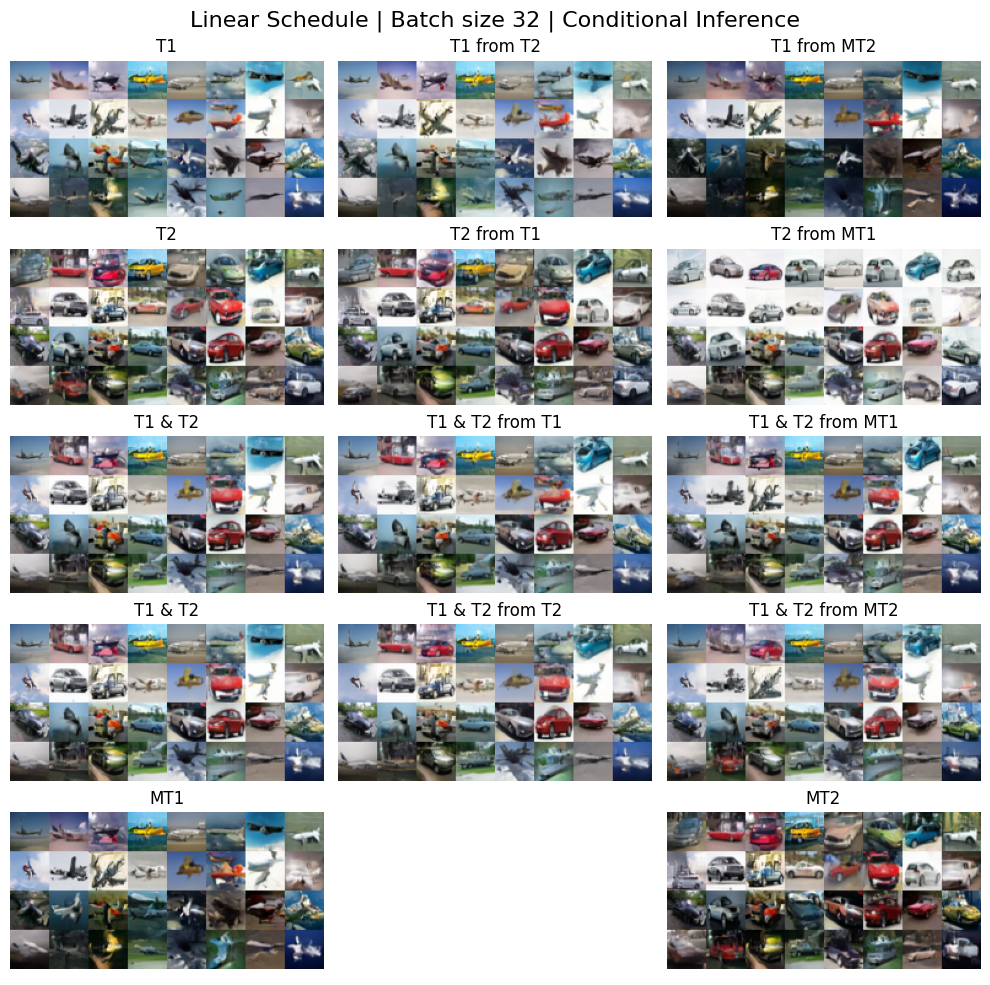

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 3, figsize=(10, 10))

axes[4, 0].imshow(get_img_given_title('MT1')); axes[4, 0].set_title("MT1")
axes[4, 2].imshow(get_img_given_title('MT2')); axes[4, 2].set_title("MT2")

axes[0, 0].imshow(get_img_given_title('T1')); axes[0, 0].set_title("T1")
axes[0, 1].imshow(get_img_given_title('T1 from T2')); axes[0, 1].set_title("T1 from T2")
axes[0, 2].imshow(get_img_given_title('T1 from MT2')); axes[0, 2].set_title("T1 from MT2")

axes[1, 0].imshow(get_img_given_title('T2')); axes[1, 0].set_title("T2")
axes[1, 1].imshow(get_img_given_title('T2 from T1')); axes[1, 1].set_title("T2 from T1")
axes[1, 2].imshow(get_img_given_title('T2 from MT1')); axes[1, 2].set_title("T2 from MT1")

axes[2, 0].imshow(get_img_given_title('T1 & T2')); axes[2, 0].set_title("T1 & T2")
axes[2, 1].imshow(get_img_given_title('T1 & T2 from T1')); axes[2, 1].set_title("T1 & T2 from T1")
axes[2, 2].imshow(get_img_given_title('T1 & T2 from MT1')); axes[2, 2].set_title("T1 & T2 from MT1")

axes[3, 0].imshow(get_img_given_title('T1 & T2')); axes[3, 0].set_title("T1 & T2")
axes[3, 1].imshow(get_img_given_title('T1 & T2 from T2')); axes[3, 1].set_title("T1 & T2 from T2")
axes[3, 2].imshow(get_img_given_title('T1 & T2 from MT2')); axes[3, 2].set_title("T1 & T2 from MT2")

# Add title to figure
fig.suptitle("Linear Schedule | Batch size 32 | Conditional Inference", fontsize=16)

# Remove all the ticks (both axes), and tick labels on the Y axis
for ax in axes.flatten(): ax.axis('off')

plt.tight_layout()